Loading 8 files...

--- Client Data Allocation ---
Client 0: 15093 Train samples, 1677 Val samples
Client 1: 2720 Train samples, 303 Val samples
Client 2: 36452 Train samples, 4051 Val samples
Client 3: 42997 Train samples, 4778 Val samples
Client 4: 19016 Train samples, 2113 Val samples

Starting Privacy-Preserving Heterogeneous FL...

--- Round 1 Statistics ---
Client 0: [Train] Acc 0.9864, F1 0.9855 | [Local Val] Acc 0.9851, F1 0.9841
Client 1: [Train] Acc 0.9353, F1 0.9226 | [Local Val] Acc 0.9142, F1 0.8885
Client 2: [Train] Acc 0.9791, F1 0.9760 | [Local Val] Acc 0.9822, F1 0.9788
Client 3: [Train] Acc 0.9810, F1 0.9768 | [Local Val] Acc 0.9799, F1 0.9762
Client 4: [Train] Acc 0.9287, F1 0.8944 | [Local Val] Acc 0.9380, F1 0.9080

--- Round 2 Statistics ---
Client 0: [Train] Acc 0.9870, F1 0.9870 | [Local Val] Acc 0.9851, F1 0.9850
Client 1: [Train] Acc 0.9581, F1 0.9514 | [Local Val] Acc 0.9373, F1 0.9239
Client 2: [Train] Acc 0.9809, F1 0.9783 | [Local Val] Acc 0.9837, F1 0.980

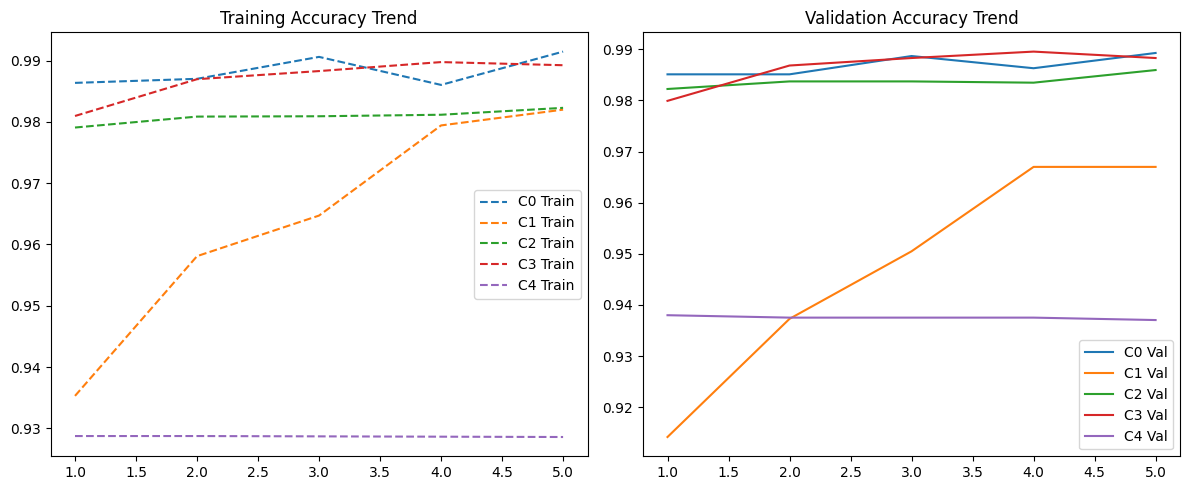

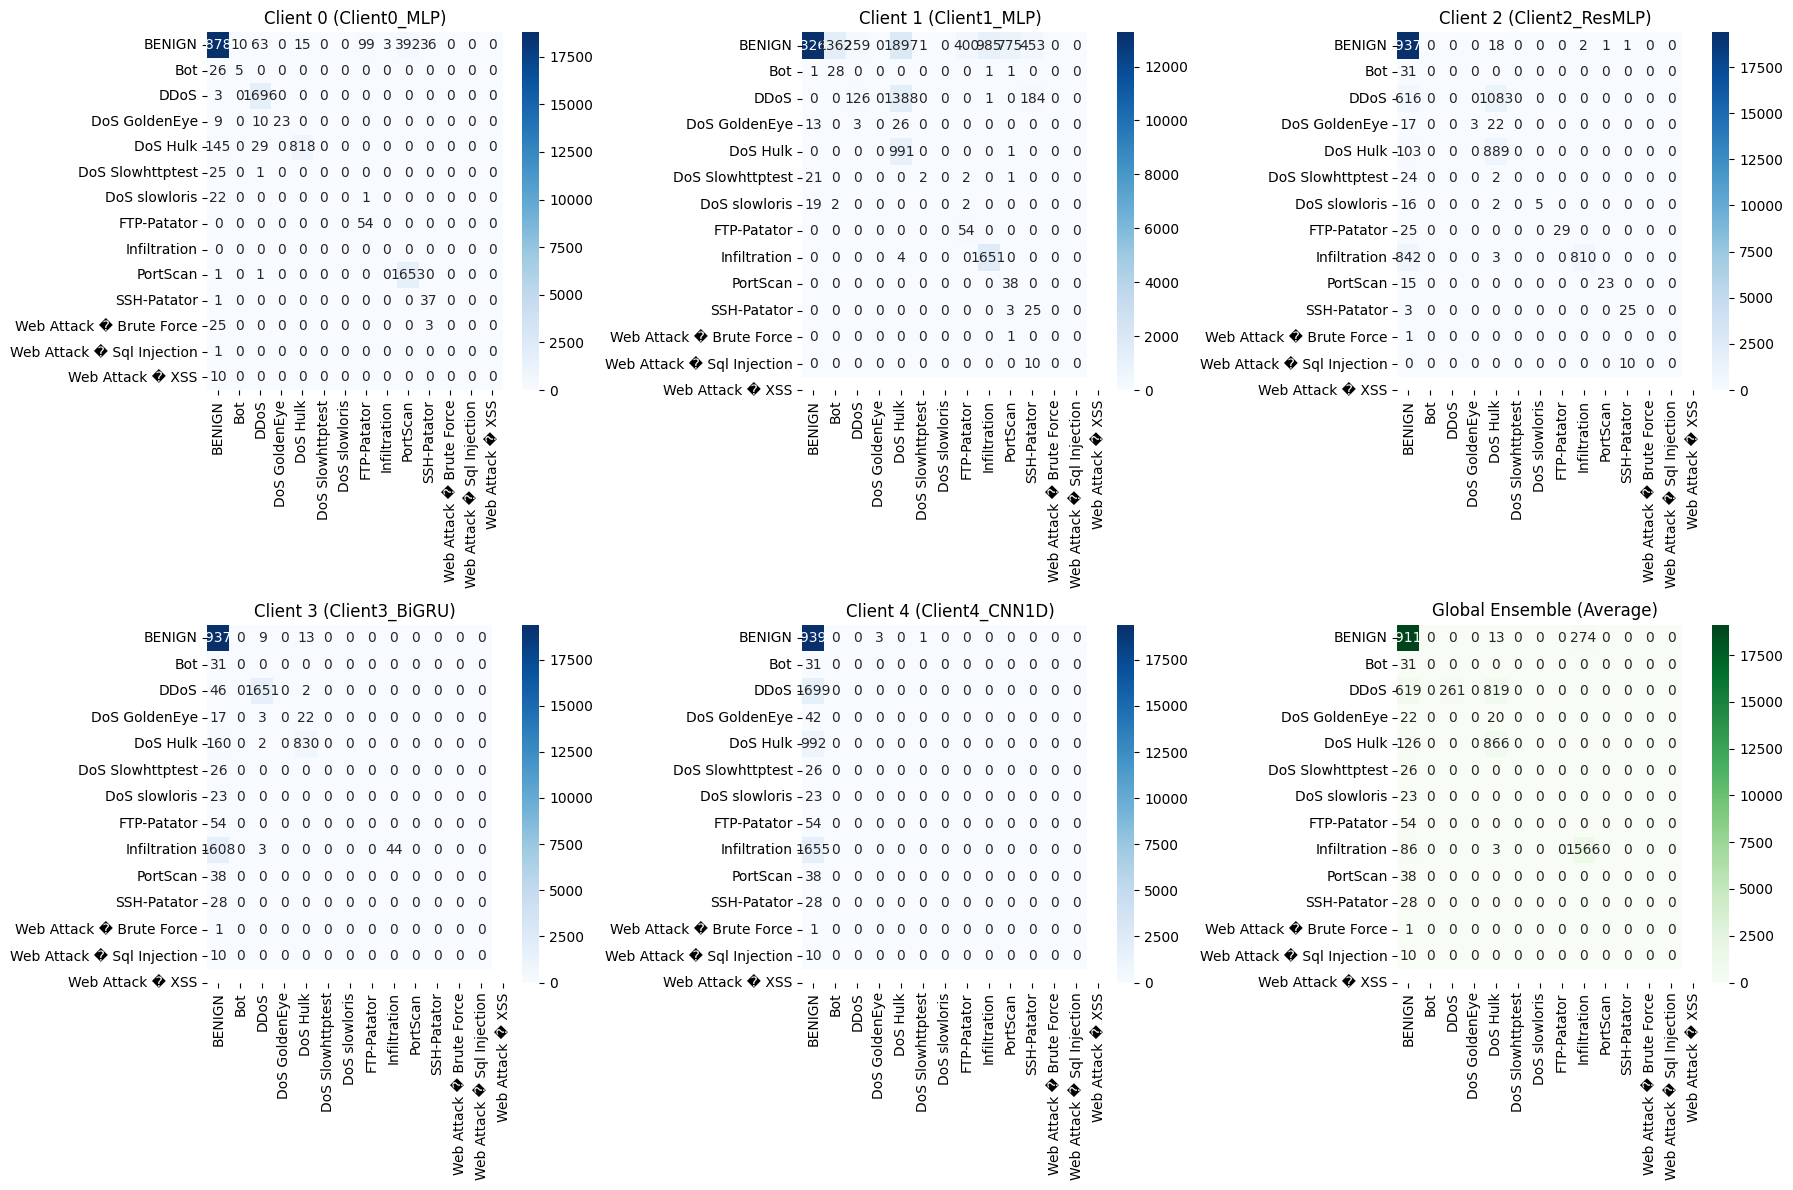


Final Global Ensemble Accuracy on Unseen Data: 0.9086


In [1]:
import os
import glob
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import tenseal as ts
import gc

# CONFIGURATION & SEEDS
SEED = 42
BATCH_SIZE = 128
NUM_CLIENTS = 5
PUBLIC_DATA_RATIO = 0.05 
VAL_SIZE = 0.1
ROUNDS = 5
LOCAL_EPOCHS = 3  # Set to 3 as requested

torch.manual_seed(SEED)
np.random.seed(SEED)

# DATA PREPARATION

# Note: Ensure this path is correct for your local machine
DATASET_DIR = r"C:\Users\SREENITHI\PrivacyPreservingFederatedLearning_IDS _HE\data"
csv_files = glob.glob(os.path.join(DATASET_DIR, "*.csv"))

mini_batches = []
SAMPLES_PER_FILE = 20000 

print(f"Loading {len(csv_files)} files...")
for f in csv_files:
    try:
        df_chunk = pd.read_csv(f)
        df_chunk.columns = df_chunk.columns.str.strip()
        df_chunk = df_chunk.replace([np.inf, -np.inf], np.nan).dropna()
        if len(df_chunk) > SAMPLES_PER_FILE:
            df_chunk = df_chunk.sample(n=SAMPLES_PER_FILE, random_state=SEED)
        mini_batches.append(df_chunk)
        del df_chunk 
        gc.collect()
    except Exception as e:
        print(f"Skipping {f}: {e}")

data = pd.concat(mini_batches, ignore_index=True)
y_raw = data["Label"].values
X_df = data.drop(columns=["Label"]).apply(pd.to_numeric, errors="coerce").fillna(0)
X_raw = np.clip(X_df.to_numpy(), -1e6, 1e6)

le = LabelEncoder()
y_all = le.fit_transform(y_raw)
OUTPUT_DIM = len(le.classes_)
INPUT_DIM = X_raw.shape[1]

# Split for the Global Unseen Test Set
X_train_full, X_test_global, y_train_full, y_test_global = train_test_split(
    X_raw, y_all, test_size=0.15, stratify=y_all, random_state=SEED
)

scaler = StandardScaler()
X_train_full = scaler.fit_transform(X_train_full)
X_test_global = scaler.transform(X_test_global) 

# Create Public Alignment Set
X_train_private, X_public, y_train_private, y_public = train_test_split(
    X_train_full, y_train_full, test_size=PUBLIC_DATA_RATIO, stratify=y_train_full, random_state=SEED
)
X_public_tensor = torch.tensor(X_public, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_global, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_global, dtype=torch.long)

#  NON-IID DATA SPLIT (DIRICHLET)

def prepare_clients(X, y, num_clients=5, alpha=0.5):
    idx_by_label = {lbl: np.where(y == lbl)[0] for lbl in np.unique(y)}
    client_indices = {i: [] for i in range(num_clients)}

    for lbl, idxs in idx_by_label.items():
        np.random.shuffle(idxs)
        proportions = (np.random.dirichlet([alpha] * num_clients) * len(idxs)).astype(int)
        while proportions.sum() < len(idxs): proportions[np.argmax(proportions)] += 1
        start = 0
        for cid, cnt in enumerate(proportions):
            client_indices[cid].extend(idxs[start:start + cnt])
            start += cnt

    clients_data = []
    print("\n--- Client Data Allocation ---")
    for cid in range(num_clients):
        idxs = client_indices[cid]
        tr_idx, val_idx = train_test_split(idxs, test_size=VAL_SIZE, random_state=SEED)
        clients_data.append({
            'train': (torch.tensor(X[tr_idx], dtype=torch.float32), torch.tensor(y[tr_idx], dtype=torch.long)),
            'val': (torch.tensor(X[val_idx], dtype=torch.float32), torch.tensor(y[val_idx], dtype=torch.long)),
            'n_samples': len(tr_idx)
        })
        print(f"Client {cid}: {len(tr_idx)} Train samples, {len(val_idx)} Val samples")
    return clients_data

clients = prepare_clients(X_train_private, y_train_private, num_clients=NUM_CLIENTS)
TOTAL_TRAIN_SAMPLES = sum(c['n_samples'] for c in clients)

#  MODELS & ENCRYPTION

context = ts.context(ts.SCHEME_TYPE.CKKS, poly_modulus_degree=8192, coeff_mod_bit_sizes=[60, 40, 40, 60])
context.generate_galois_keys()
context.global_scale = 2**40

class Client0_MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(INPUT_DIM, 512), nn.ReLU(), nn.Linear(512, OUTPUT_DIM))
    def forward(self, x): return self.net(x)

class Client1_MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(INPUT_DIM, 256), nn.ReLU(), nn.Linear(256, OUTPUT_DIM))
    def forward(self, x): return self.net(x)

class Client2_ResMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1, self.fc2 = nn.Linear(INPUT_DIM, 256), nn.Linear(256, OUTPUT_DIM)
    def forward(self, x): return self.fc2(F.relu(self.fc1(x)))

class Client3_BiGRU(nn.Module):
    def __init__(self):
        super().__init__()
        self.gru = nn.GRU(1, 64, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(128, OUTPUT_DIM)
    def forward(self, x):
        _, h = self.gru(x.unsqueeze(-1))
        return self.fc(torch.cat((h[-2], h[-1]), dim=1))

class Client4_CNN1D(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv1d(1, 32, 3, padding=1)
        self.fc = nn.Linear(32, OUTPUT_DIM)
    def forward(self, x):
        x = F.adaptive_avg_pool1d(F.relu(self.conv(x.unsqueeze(1))), 1)
        return self.fc(x.squeeze(-1))

models = {0: Client0_MLP(), 1: Client1_MLP(), 2: Client2_ResMLP(), 3: Client3_BiGRU(), 4: Client4_CNN1D()}
optimizers = {cid: optim.Adam(models[cid].parameters(), lr=1e-3) for cid in range(NUM_CLIENTS)}

#  HELPERS & LOGGING

# To store accuracy for the graph
history_val = {cid: [] for cid in range(NUM_CLIENTS)}
history_train = {cid: [] for cid in range(NUM_CLIENTS)}

def get_metrics(model, X, y):
    model.eval()
    with torch.no_grad():
        preds = torch.argmax(model(X), dim=1).cpu().numpy()
        y_true = y.cpu().numpy()
    return accuracy_score(y_true, preds), f1_score(y_true, preds, average="weighted")

def local_train_and_encrypt(cid):
    model, opt = models[cid], optimizers[cid]
    Xc, yc = clients[cid]['train']
    
    model.train()
    # Apply Local Epochs
    for epoch in range(LOCAL_EPOCHS):
        for i in range(0, len(Xc), BATCH_SIZE):
            opt.zero_grad()
            loss = F.cross_entropy(model(Xc[i:i+BATCH_SIZE]), yc[i:i+BATCH_SIZE])
            loss.backward()
            opt.step()

    model.eval()
    with torch.no_grad():
        avg_logits = model(X_public_tensor).mean(dim=0).cpu().numpy()
    
    weight = clients[cid]['n_samples'] / TOTAL_TRAIN_SAMPLES
    return ts.ckks_vector(context, avg_logits * weight)

def server_aggregate(encrypted_list):
    agg = encrypted_list[0]
    for i in range(1, len(encrypted_list)):
        agg += encrypted_list[i]
    return agg

def client_decryption_and_distill(cid, encrypted_global_vec):
    global_logits_plaintext = encrypted_global_vec.decrypt() 
    target = torch.tensor(global_logits_plaintext, dtype=torch.float32)
    
    model, opt = models[cid], optimizers[cid]
    model.train()
    opt.zero_grad()
    loss = F.mse_loss(model(X_public_tensor).mean(dim=0), target)
    loss.backward()
    opt.step()

#  EXECUTION LOOP

print("\nStarting Privacy-Preserving Heterogeneous FL...")

for r in range(ROUNDS):
    # Step 1: Local training & Encryption
    ciphertexts = [local_train_and_encrypt(cid) for cid in range(NUM_CLIENTS)]
    
    # Step 2: Server-side blind aggregation
    encrypted_global = server_aggregate(ciphertexts)
    
    # Step 3: Local Distillation (Privacy preserved)
    for cid in range(NUM_CLIENTS):
        client_decryption_and_distill(cid, encrypted_global)

    # Step 4: Collect Round Stats (Printing both Train and Val)
    print(f"\n--- Round {r+1} Statistics ---")
    for cid in range(NUM_CLIENTS):
        t_acc, t_f1 = get_metrics(models[cid], clients[cid]['train'][0], clients[cid]['train'][1])
        v_acc, v_f1 = get_metrics(models[cid], clients[cid]['val'][0], clients[cid]['val'][1])
        
        history_train[cid].append(t_acc)
        history_val[cid].append(v_acc)
        
        print(f"Client {cid}: [Train] Acc {t_acc:.4f}, F1 {t_f1:.4f} | [Local Val] Acc {v_acc:.4f}, F1 {v_f1:.4f}")

#  FINAL GLOBAL EVALUATION & PLOTTING


# Global Ensemble Function
def get_predictions(model, X):
    model.eval()
    with torch.no_grad():
        return model(X)

def ensemble_predict(models_dict, X):
    outputs = [get_predictions(models_dict[cid], X) for cid in models_dict]
    avg_output = torch.stack(outputs).mean(dim=0)
    return torch.argmax(avg_output, dim=1).cpu().numpy()

# Plot Performance Trends
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for cid in range(NUM_CLIENTS):
    plt.plot(range(1, ROUNDS+1), history_train[cid], label=f'C{cid} Train', linestyle='--')
plt.title('Training Accuracy Trend')
plt.legend()

plt.subplot(1, 2, 2)
for cid in range(NUM_CLIENTS):
    plt.plot(range(1, ROUNDS+1), history_val[cid], label=f'C{cid} Val')
plt.title('Validation Accuracy Trend')
plt.legend()
plt.tight_layout()
plt.show()

# Confusion Matrices for ALL Clients + Ensemble
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for cid in range(NUM_CLIENTS):
    y_pred = torch.argmax(models[cid](X_test_tensor), dim=1).cpu().numpy()
    cm = confusion_matrix(y_test_global, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[cid], 
                xticklabels=le.classes_, yticklabels=le.classes_)
    axes[cid].set_title(f'Client {cid} ({models[cid].__class__.__name__})')

# Add Ensemble to the 6th slot
y_pred_ens = ensemble_predict(models, X_test_tensor)
cm_ens = confusion_matrix(y_test_global, y_pred_ens)
sns.heatmap(cm_ens, annot=True, fmt='d', cmap='Greens', ax=axes[5], 
            xticklabels=le.classes_, yticklabels=le.classes_)
axes[5].set_title('Global Ensemble (Average)')

plt.tight_layout()
plt.show()

# Final Metrics Output
ens_acc = accuracy_score(y_test_global, y_pred_ens)
print(f"\nFinal Global Ensemble Accuracy on Unseen Data: {ens_acc:.4f}")

In [2]:
print("\n--- Client-wise Class Distribution ---")
for cid in range(NUM_CLIENTS):
    y_client = clients[cid]['train'][1].cpu().numpy()
    unique, counts = np.unique(y_client, return_counts=True)
    dist = dict(zip(le.inverse_transform(unique), counts))
    print(f"Client {cid}: {dist}")



--- Client-wise Class Distribution ---
Client 0: {'BENIGN': 3809, 'Bot': 11, 'DDoS': 5542, 'DoS GoldenEye': 6, 'DoS Hulk': 46, 'FTP-Patator': 124, 'Infiltration': 2, 'PortScan': 5508, 'SSH-Patator': 42, 'Web Attack � Brute Force': 2, 'Web Attack � Sql Injection': 1}
Client 1: {'BENIGN': 74, 'Bot': 86, 'DDoS': 11, 'DoS Hulk': 852, 'DoS Slowhttptest': 1, 'FTP-Patator': 77, 'PortScan': 1488, 'SSH-Patator': 71, 'Web Attack � Brute Force': 56, 'Web Attack � XSS': 4}
Client 2: {'BENIGN': 32861, 'Bot': 3, 'DoS GoldenEye': 1, 'DoS Hulk': 3058, 'DoS slowloris': 1, 'FTP-Patator': 44, 'PortScan': 353, 'SSH-Patator': 39, 'Web Attack � Brute Force': 55, 'Web Attack � XSS': 37}
Client 3: {'BENIGN': 39592, 'Bot': 26, 'DDoS': 2620, 'DoS GoldenEye': 17, 'DoS Hulk': 505, 'DoS Slowhttptest': 17, 'DoS slowloris': 21, 'PortScan': 175, 'SSH-Patator': 22, 'Web Attack � XSS': 2}
Client 4: {'BENIGN': 17661, 'Bot': 23, 'DDoS': 27, 'DoS GoldenEye': 180, 'DoS Hulk': 362, 'DoS Slowhttptest': 108, 'DoS slowloris':

In [3]:
print("\n--- Final Client-wise Performance ---")
for cid in range(NUM_CLIENTS):
    acc, f1 = get_metrics(models[cid], X_test_tensor, y_test_tensor)
    print(f"Client {cid} ({models[cid].__class__.__name__}): "
          f"Test Acc = {acc:.4f}, Test F1 = {f1:.4f}")



--- Final Client-wise Performance ---
Client 0 (Client0_MLP): Test Acc = 0.9612, Test F1 = 0.9608
Client 1 (Client1_MLP): Test Acc = 0.6743, Test F1 = 0.7335
Client 2 (Client2_ResMLP): Test Acc = 0.8818, Test F1 = 0.8480
Client 3 (Client3_BiGRU): Test Acc = 0.9127, Test F1 = 0.8774
Client 4 (Client4_CNN1D): Test Acc = 0.8082, Test F1 = 0.7226


In [4]:
ens_acc = accuracy_score(y_test_global, y_pred_ens)
ens_f1 = f1_score(y_test_global, y_pred_ens, average="weighted")

print("\n--- Global Ensemble Performance ---")
print(f"Ensemble Accuracy: {ens_acc:.4f}")
print(f"Ensemble F1-score: {ens_f1:.4f}")



--- Global Ensemble Performance ---
Ensemble Accuracy: 0.9086
Ensemble F1-score: 0.8878


In [5]:
# =========================
# DATASET STATISTICS REPORT
# =========================

total_samples = len(X_raw)

train_samples = len(X_train_full)
test_samples = len(X_test_global)

private_train_samples = len(X_train_private)
public_samples = len(X_public)

# Validation samples across all clients
total_val_samples = sum(len(c['val'][0]) for c in clients)
total_private_train_samples = sum(len(c['train'][0]) for c in clients)

print("===== Dataset Summary =====")
print(f"Total Samples               : {total_samples}")

print("\n===== Global Split =====")
print(f"Training Samples            : {train_samples} ({train_samples/total_samples*100:.2f}%)")
print(f"Test Samples                : {test_samples} ({test_samples/total_samples*100:.2f}%)")

print("\n===== Training Set Breakdown =====")
print(f"Private Training Samples    : {private_train_samples} ({private_train_samples/total_samples*100:.2f}%)")
print(f"Public Samples              : {public_samples} ({public_samples/total_samples*100:.2f}%)")

print("\n===== Client-side Split =====")
print(f"Private Train (Clients)     : {total_private_train_samples} ({total_private_train_samples/total_samples*100:.2f}%)")
print(f"Validation Samples          : {total_val_samples} ({total_val_samples/total_samples*100:.2f}%)")

print("\n===== Sanity Check =====")
print(f"Train + Test = {train_samples + test_samples} (should equal Total Samples)")
print(f"Private + Public = {private_train_samples + public_samples} (should equal Training Samples)")


===== Dataset Summary =====
Total Samples               : 160000

===== Global Split =====
Training Samples            : 136000 (85.00%)
Test Samples                : 24000 (15.00%)

===== Training Set Breakdown =====
Private Training Samples    : 129200 (80.75%)
Public Samples              : 6800 (4.25%)

===== Client-side Split =====
Private Train (Clients)     : 116278 (72.67%)
Validation Samples          : 12922 (8.08%)

===== Sanity Check =====
Train + Test = 160000 (should equal Total Samples)
Private + Public = 136000 (should equal Training Samples)
